# Hello, KAN!

### Kolmogorov-Arnold representation theorem

Kolmogorov-Arnold representation theorem states that if $f$ is a multivariate continuous function
on a bounded domain, then it can be written as a finite composition of continuous functions of a
single variable and the binary operation of addition. More specifically, for a smooth $f : [0,1]^n \to \mathbb{R}$,


$$f(x) = f(x_1,...,x_n)=\sum_{q=1}^{2n+1}\Phi_q(\sum_{p=1}^n \phi_{q,p}(x_p))$$

where $\phi_{q,p}:[0,1]\to\mathbb{R}$ and $\Phi_q:\mathbb{R}\to\mathbb{R}$. In a sense, they showed that the only true multivariate function is addition, since every other function can be written using univariate functions and sum. However, this 2-Layer width-$(2n+1)$ Kolmogorov-Arnold representation may not be smooth due to its limited expressive power. We augment its expressive power by generalizing it to arbitrary depths and widths.

### Kolmogorov-Arnold Network (KAN)

The Kolmogorov-Arnold representation can be written in matrix form

$$f(x)={\bf \Phi}_{\rm out}\circ{\bf \Phi}_{\rm in}\circ {\bf x}$$

where 

$${\bf \Phi}_{\rm in}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n}(\cdot) \\ \vdots & & \vdots \\ \phi_{2n+1,1}(\cdot) & \cdots & \phi_{2n+1,n}(\cdot) \end{pmatrix},\quad {\bf \Phi}_{\rm out}=\begin{pmatrix} \Phi_1(\cdot) & \cdots & \Phi_{2n+1}(\cdot)\end{pmatrix}$$

We notice that both ${\bf \Phi}_{\rm in}$ and ${\bf \Phi}_{\rm out}$ are special cases of the following function matrix ${\bf \Phi}$ (with $n_{\rm in}$ inputs, and $n_{\rm out}$ outputs), we call a Kolmogorov-Arnold layer:

$${\bf \Phi}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n_{\rm in}}(\cdot) \\ \vdots & & \vdots \\ \phi_{n_{\rm out},1}(\cdot) & \cdots & \phi_{n_{\rm out},n_{\rm in}}(\cdot) \end{pmatrix}$$

${\bf \Phi}_{\rm in}$ corresponds to $n_{\rm in}=n, n_{\rm out}=2n+1$, and ${\bf \Phi}_{\rm out}$ corresponds to $n_{\rm in}=2n+1, n_{\rm out}=1$.

After defining the layer, we can construct a Kolmogorov-Arnold network simply by stacking layers! Let's say we have $L$ layers, with the $l^{\rm th}$ layer ${\bf \Phi}_l$ have shape $(n_{l+1}, n_{l})$. Then the whole network is

$${\rm KAN}({\bf x})={\bf \Phi}_{L-1}\circ\cdots \circ{\bf \Phi}_1\circ{\bf \Phi}_0\circ {\bf x}$$

In constrast, a Multi-Layer Perceptron is interleaved by linear layers ${\bf W}_l$ and nonlinearities $\sigma$:

$${\rm MLP}({\bf x})={\bf W}_{L-1}\circ\sigma\circ\cdots\circ {\bf W}_1\circ\sigma\circ {\bf W}_0\circ {\bf x}$$

A KAN can be easily visualized. (1) A KAN is simply stack of KAN layers. (2) Each KAN layer can be visualized as a fully-connected layer, with a 1D function placed on each edge. Let's see an example below.

### Get started with KANs

Initialize KAN

In [3]:
from kan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

Create dataset

In [4]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

Plot KAN at initialization

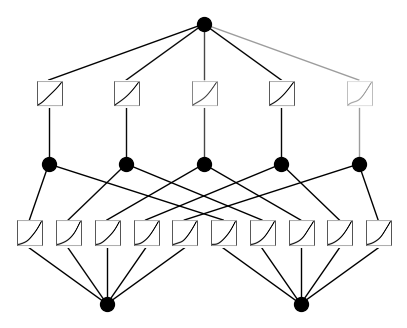

In [3]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100)

In [4]:
# params save stem
dir_stem = 'params'
os.makedirs(dir_stem, exist_ok=True)

In [5]:
# Save the initial parameters
theta0 = model.state_dict().copy()
torch.save(theta0, os.path.join(dir_stem, 'theta0.pth'))
print('Saved initial parameters to', os.path.join(dir_stem, 'theta0.pth'))

Saved initial parameters to params/theta0.pth


Train KAN with sparsity regularization

In [6]:
# train the model
model.train_model(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.);

train loss: 1.23e-01 | test loss: 1.26e-01 | reg: 1.86e+01 : 100%|██| 20/20 [00:13<00:00,  1.49it/s]


Plot trained KAN

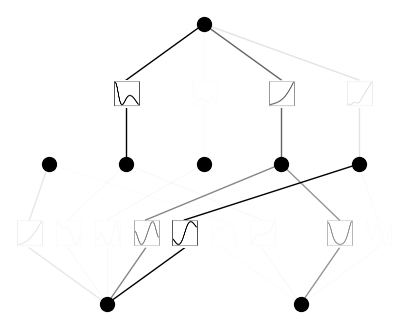

In [7]:
model.plot()

In [8]:
# Save the initial parameters
thetaN = model.state_dict().copy()
torch.save(thetaN, os.path.join(dir_stem, 'thetaN.pth'))
print('Saved final parameters to', os.path.join(dir_stem, 'thetaN.pth'))

Saved final parameters to params/thetaN.pth


Prune KAN and replot (keep the original shape)

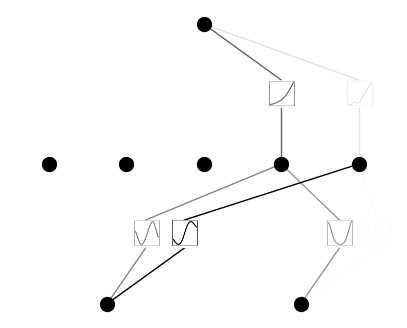

In [9]:
model.prune()
model.plot(mask=True)

Prune KAN and replot (get a smaller shape)

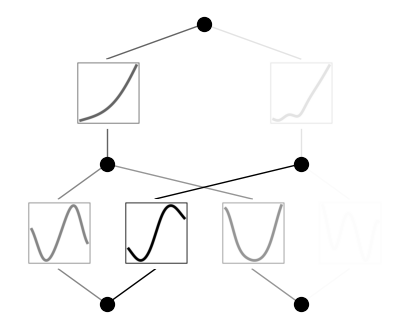

In [10]:
model = model.prune()
model(dataset['train_input'])
model.plot()

Continue training and replot

In [11]:
model.train_model(dataset, opt="LBFGS", steps=50);

train loss: 3.43e-03 | test loss: 3.45e-03 | reg: 5.30e+00 : 100%|██| 50/50 [00:21<00:00,  2.29it/s]


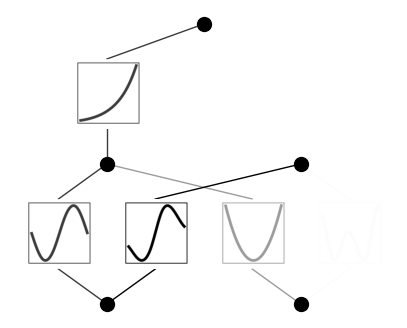

In [12]:
model.plot()

Automatically or manually set activation functions to be symbolic

In [13]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999678730964661
fixing (0,0,1) with sin, r2=0.9901396036148071
fixing (0,1,0) with x^2, r2=0.9999998807907104
fixing (0,1,1) with sin, r2=0.8737531304359436
fixing (1,0,0) with exp, r2=0.9999983310699463
fixing (1,1,0) with tanh, r2=0.9509005546569824


Continue training to almost machine precision

In [14]:
model.train_model(dataset, opt="LBFGS", steps=50);

train loss: 1.61e-06 | test loss: 1.55e-06 | reg: 5.18e+00 : 100%|██| 50/50 [00:06<00:00,  7.42it/s]


Obtain the symbolic formula

In [15]:
model.symbolic_formula()[0][0]

1.0*exp(1.0*x_2**2 + 1.0*sin(3.14*x_1))

## Is KAN convex? 
No... :(

In [1]:
from kan import *

In [2]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [3]:
# Load initial and final parameters
dir_stem = 'params'
theta0 = torch.load(os.path.join(dir_stem, 'theta0.pth'))
thetaN = torch.load(os.path.join(dir_stem, 'thetaN.pth'))

# Linearly interpolate/extrapolate the parameters between theta0 and thetaN
alphas = np.linspace(-1.5, 2.0, 50)
thetas = [{name: (1-alpha)*theta0[name] + alpha*thetaN[name] for name in theta0} for alpha in alphas]

In [4]:
# Set up the model and define the loss
model = KAN(width=[2,5,1], grid=5, k=3)
criterion = nn.MSELoss()

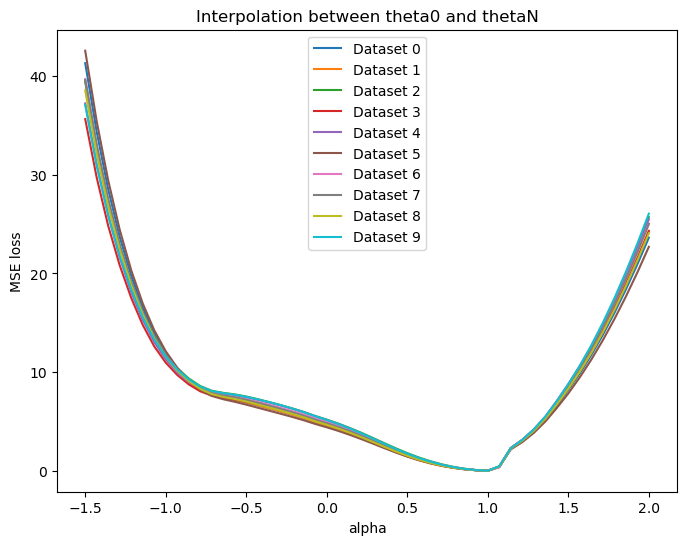

In [5]:
n_datasets = 10

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(n_datasets):
    # Create a new dataset
    dataset = create_dataset(f, n_var=2, seed=i)
    data = dataset['train_input']
    targets = dataset['train_label']

    # Compute the loss for each theta
    losses = []
    with torch.no_grad():  # No need to compute gradients for evaluation
        for theta in thetas:
            model.load_state_dict(theta)
            outputs = model(data)
            loss = criterion(outputs, targets)
            losses.append(loss.item())

    # Plot the loss as a function of alpha
    ax.plot(alphas, losses, label=f'Dataset {i}')

# add legend for each line
ax.legend()

plt.xlabel('alpha')
plt.ylabel('MSE loss')
plt.title('Interpolation between theta0 and thetaN')
plt.show()

### Spectrum Density

In [6]:
from kan import *
from pyhessian import hessian, get_esd_plot # Hessian computation
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
# Set up the model and define the loss
model = KAN(width=[2,5,1], grid=5, k=3)
criterion = nn.MSELoss()

In [8]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)

In [9]:
# Dataset
inputs = dataset['train_input']
targets = dataset['train_label']

In [16]:
pdf = PdfPages('figures/spec_density/kan.pdf')
for i, theta in enumerate(thetas):
    model.load_state_dict(theta)
    hessian_comp = hessian(model, criterion, data=(inputs,targets), cuda=False) 
    density_eigen, density_weight = hessian_comp.density()
    fig, ax = get_esd_plot(density_eigen, density_weight)
    ax.set_title(f'Spectrum of Hessian for alpha={alphas[i]:.2f}')
    pdf.savefig(fig, bbox_inches = 'tight')
    plt.close(fig)
pdf.close()        

/Users/ycchu/Documents/Research/KAN/code/pykan2/pykan/pyhessian/density_plot.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


### Eigvalue

In [11]:
hessian_comp = hessian(model, criterion, data=(inputs,targets), cuda=False)

In [12]:
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[-1])

The top Hessian eigenvalue of this model is 124.7160


In [13]:
# Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
print("The top two eigenvalues of this model are: %.4f %.4f"% (top_eigenvalues[-1],top_eigenvalues[-2]))

The top two eigenvalues of this model are: 74.0288 124.7734


In [14]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 226.4016
